# Demo for multi-objective molecular generation with ScafVAE
## Step 1. Loading dependencies
#### P.S. To use your own trained model, please change the path of "model_param_path" in ScafVAE_ROOT/model/config.yml to your saving path as described in `demo_pretraining.ipynb` before loading dependencies (P.S. please use absolute path).

In [1]:
from ScafVAE.app.demo_utils import *

## Step 2. Training surrogate models for properties of interest
#### In this demo, we aim to generate dual-target drug candidates inhibit EGFR and HER2, which act synergistically in preclinical experiments (Konecny, Gottfried E., et al. Cancer research 66.3 (2006): 1630-1639.)

In [2]:
df_EGFR, df_HER2 = get_demo_properties(max_num=5000, name='binding')  # get inhibition data for two target proteins

df_EGFR  # 1 for active binders

,idx,smi,label
0,0,Nc1ncnc2n(nc(-c3ccccc3)c12)-c1ccccc1,1
1,1,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,1
2,2,Cn1c2nc(N)ncc2cc(-c2c(Cl)cccc2Cl)c1=O,0
3,3,CNc1ncc2cc(-c3c(Cl)cccc3Cl)c(=O)n(C)c2n1,0
4,4,CCNc1ncc2cc(-c3c(Cl)cccc3Cl)c(=O)n(C)c2n1,0
...,...,...,...
4995,4995,Cc1nc(ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)(C...,1
4996,4996,Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC3(C...,1
4997,4997,Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)...,1
4998,4998,Cc1nc(F)ccc1[C@H](Nc1cc(C#N)c2ncc(C#N)c(NCC(C)...,1


In [3]:
generation_path = './generation'  # path for saving data
device = 'cuda'  # device for DL model: cpu / cuda
tasks = [
    {
        # task name
        'name': 'EGFR_inhibition',

        # input data (pandas DataFrame)
        # columns: idx (unique index or ID for each molecule) / smi (SMILES) / label (values of property)
        'data': df_EGFR,

        # task type: classification / regression
        'task_type': 'classification',

        # ML model for surrogate model, string or initialized model object of sklearn:
        # adaboost / SVM / KNN / MLP / RF or e.g., RandomForestClassifier() ...
        # If using a name string, the model is trained with a grid search
        # P.S. If the dataset is too small (<200), error may occur in grid search. Then you shall use your own initialized model object.
        'ML_model': 'RF',

        # property is need to be maximized or minimized: max / min
        'optimization_type': 'max',

        # pseudo weight for this property
        'pseudo_weight': 0.5,
    },
    {
        'name': 'HER2_inhibition',
        'data': df_HER2,
        'task_type': 'classification',
        'ML_model': 'RF',
        'optimization_type': 'max',
        'pseudo_weight': 0.5,
    },
]

#### Preparing data and training surrogate model

In [4]:
base_model, surrogate_model = prepare_data_and_train(generation_path, tasks, device=device, n_jobs=32)

Loading ScafVAE parameters ...
Preparing EGFR_inhibition ...


Calculating EGFR_inhibition latent vectors: 100%|█████████████████████████████████████████████████| 157/157 [01:47<00:00,  1.46it/s]


EGFR_inhibition done.
Preparing HER2_inhibition ...


Calculating HER2_inhibition latent vectors: 100%|█████████████████████████████████████████████████| 156/156 [01:43<00:00,  1.50it/s]


HER2_inhibition done.
Training surrogate model for EGFR_inhibition ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Finished training - 15.0s
EGFR_inhibition done.
Training surrogate model for HER2_inhibition ...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Finished training - 50.3s
HER2_inhibition done.


#### Visualization
We plot the ROC curve below to evaluate the accuracy

In [5]:
def plot_ROC(name):
    model = surrogate_model[name]['automl']
    x_test = surrogate_model[name]['x_test']
    y_test = surrogate_model[name]['y_test']

    y_pred = model.predict(x_test)

    metric = 'ROC-AUC'  # ROC-AUC / Spearman
    score = AutoML.calc_metric(y_test, y_pred, metric)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

    sns.set_style('whitegrid')
    sns.set_context('talk')

    fig, ax = plt.subplots(1, 1, figsize=(8, 7))
    ax.plot(fpr, tpr, lw=2.0)
    ax.plot([0, 1], [0, 1], lw=2.0, linestyle='--', color='k')

    ax.set_ylabel(f'True positive rate')
    ax.set_xlabel(f'False positive rate')
    ax.set_title(f'{name} test set {metric}: {score:.3f}')
    fig.tight_layout()
    plt.show()

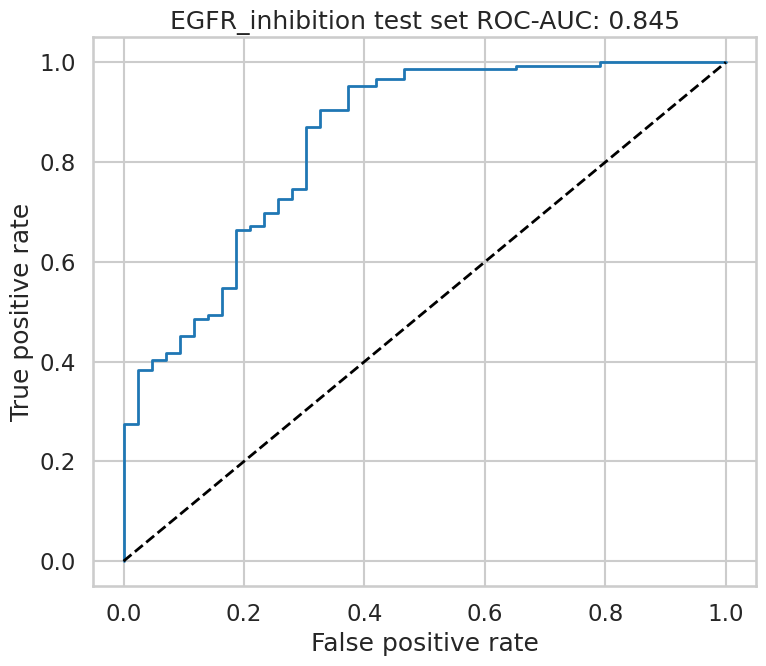

In [6]:
plot_ROC('EGFR_inhibition')

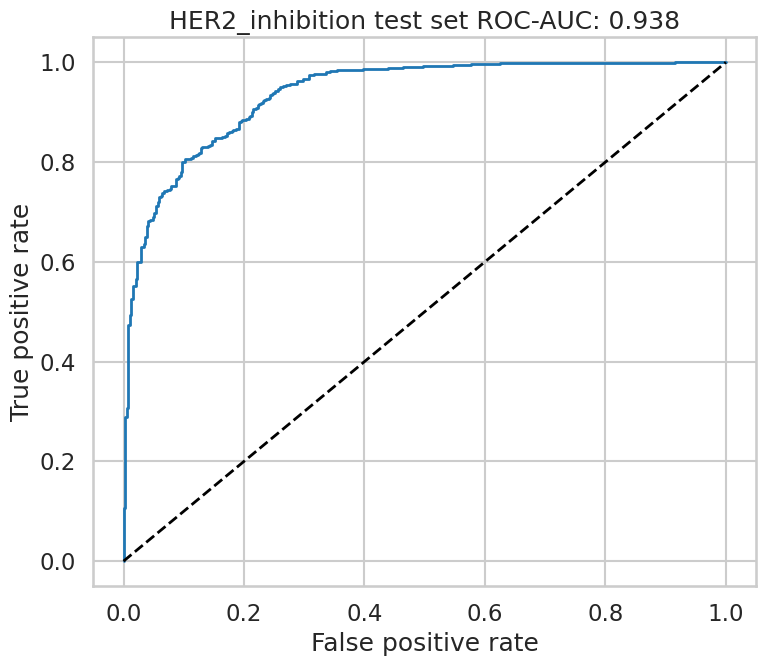

In [7]:
plot_ROC('HER2_inhibition')

## Step 3. Generating multi-objective molecules
#### Molecular generation by Bayesian optimization (BO)

In [8]:
df_output = generate_mol(
    10,  # number of generated molecules
    generation_path, tasks, base_model, surrogate_model,
    MAXGEN=200,  # max iteration for BO
    multi_cpu=False,  # using multiple CPUs, if the surrogate models are heavy.
    seed=42,
)
df_output

Generating molecules:   0%|          | 0/10 [00:00<?, ?it/s]

,seed,smi,predicted EGFR_inhibition,predicted HER2_inhibition
0,42,CN(Cc1cc(N)cc(C#N)c1)c1cc(Cl)c(OCC(NC2CCc3c(oc...,0.762006,0.786367
1,43,CCOc1cc2c(C#N)cnn2cc1NC1C2COCC2CC1(O)Nc1ncc(F)...,0.750494,0.787645
2,44,CCC(CNC1CC1COc1cc2c(N)ncnc2cc1OCC1CCC(C#N)CO1)...,0.750101,0.785690
3,45,CN1CCn2ncc(OCc3cnc(NCCCl)nc3)c2C1c1ccc(Cl)c(OC...,0.725985,0.792751
4,46,[H]c1c(F)c(C(C([H])([H])[H])(C([H])([H])[H])C(...,0.749352,0.785286
5,47,CC(Nc1cnc(NC2CC3COCC3C2)c2cc(Br)cn12)Oc1cc(OCC...,0.748854,0.789320
6,48,CCCC(CNCC1CCC1)Nc1ccc2nnc(Nc3cc(F)cc4cc(OC5CCC...,0.752224,0.789173
7,49,COCC(CC1CN(N=[SH](=O)c2cc(F)ccc2Nc2ccc(F)cc2F)...,0.752995,0.785636
8,50,CC1(C)CC2CC(CN(c3ccc(Cl)c4ncc(OCc5cncc(Cl)c5)c...,0.757049,0.783437
9,51,COCCN(Nc1ncnc2nnc(OC3CCN4CCOC34)c(Cl)c12)C(C)c...,0.761749,0.778609


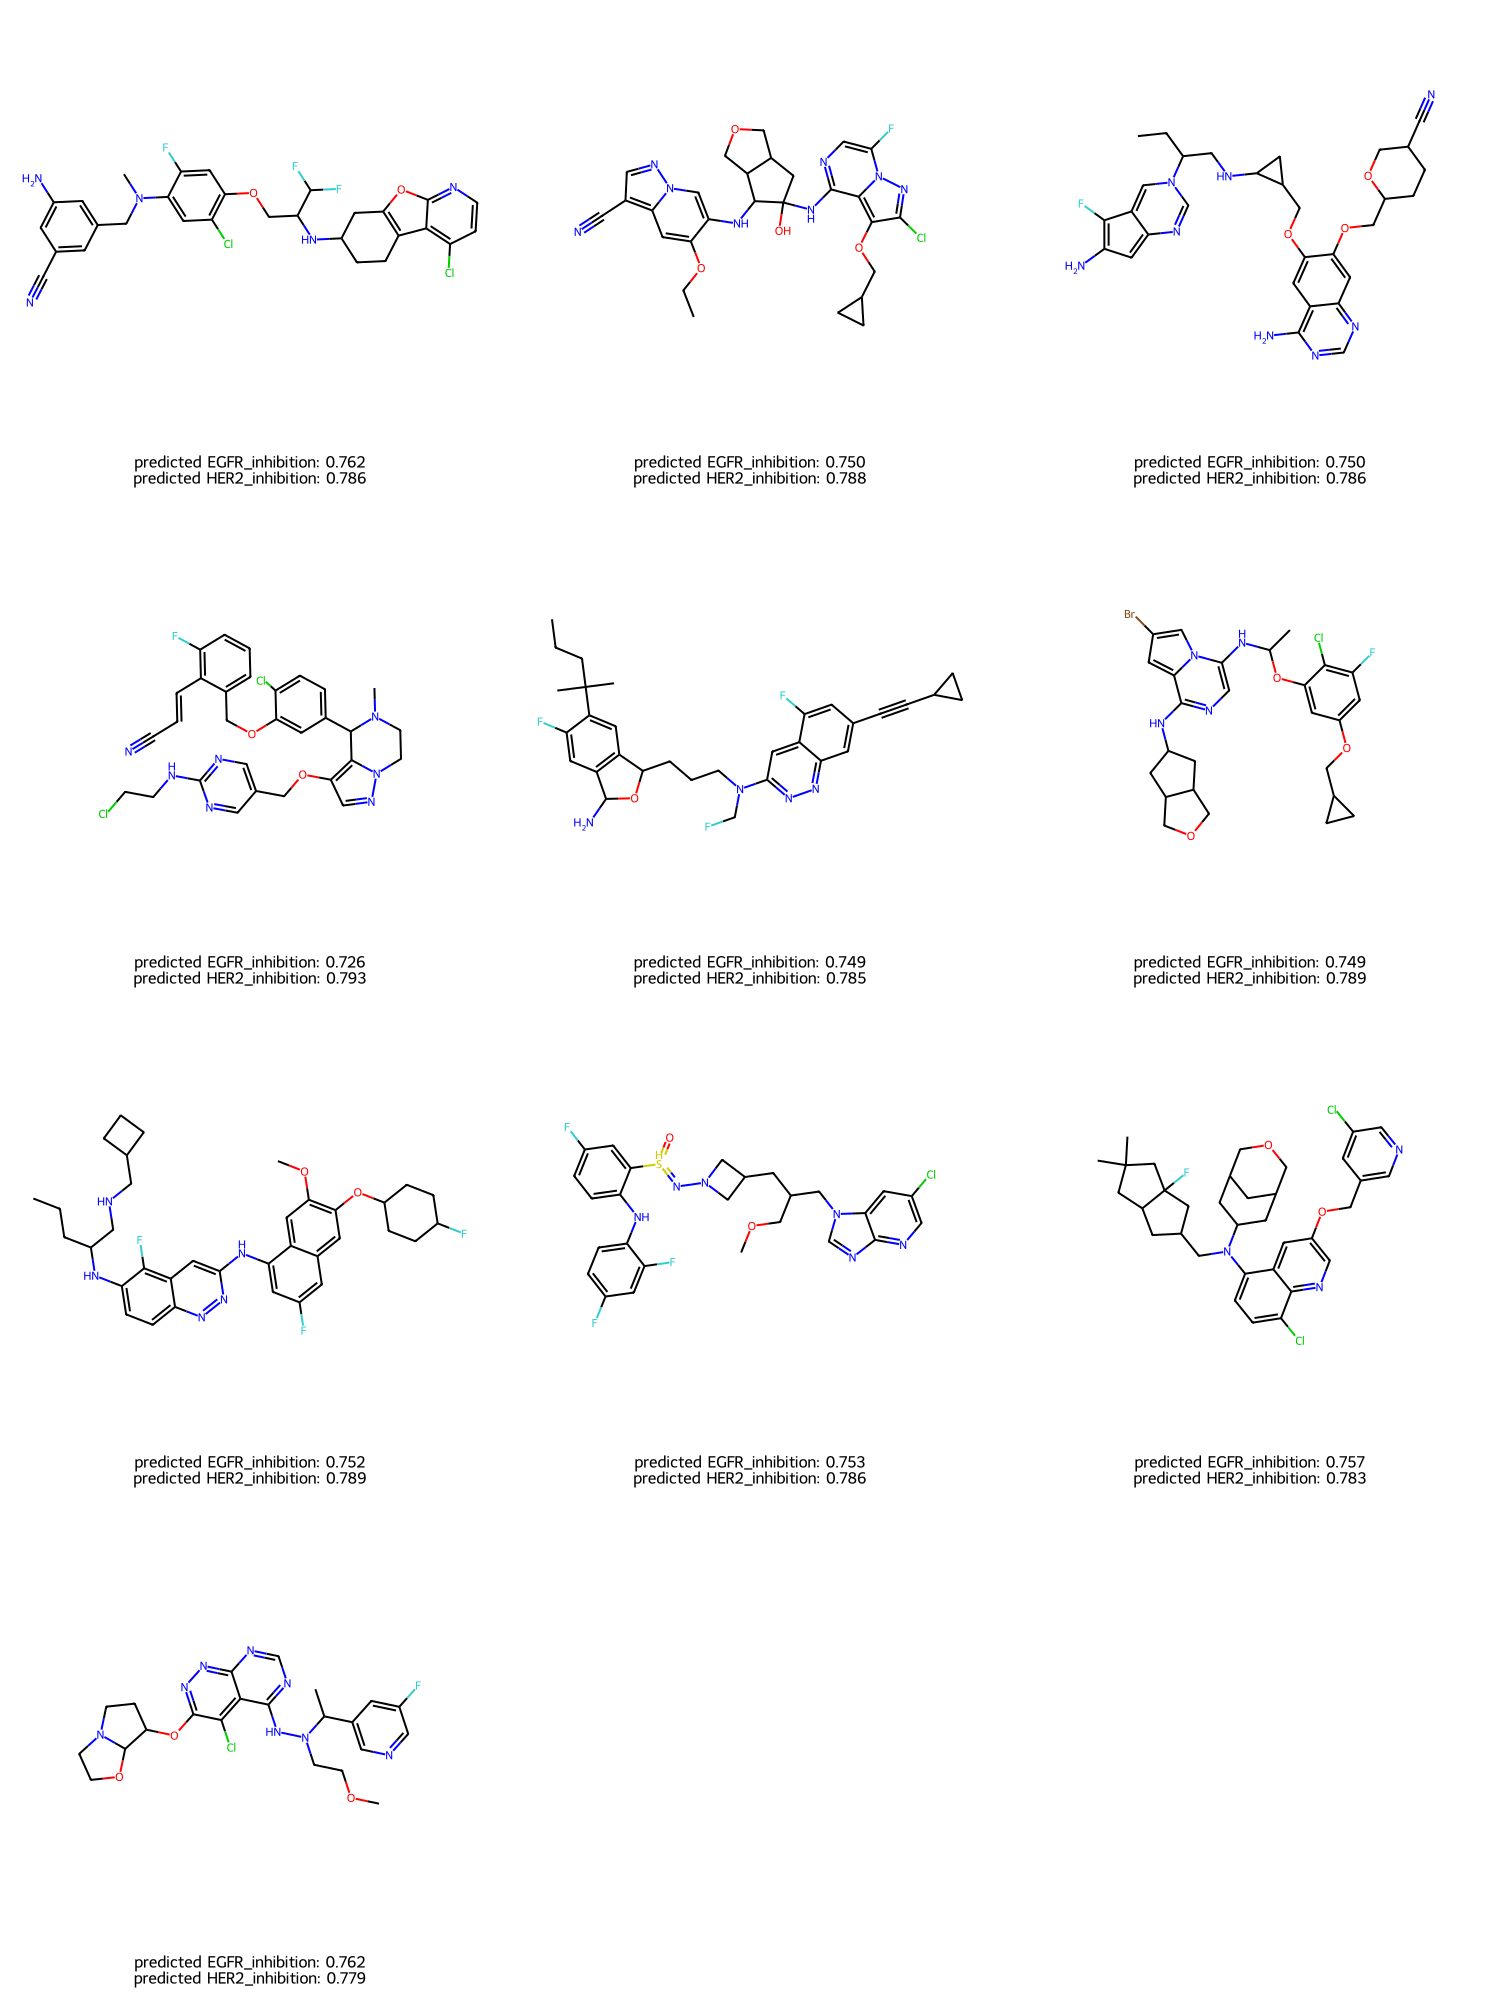

In [9]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smi) for smi in df_output['smi']],
    legends=[
        f"{'predicted ' + tasks[0]['name']}: {p1:.3f}\n{'predicted ' + tasks[1]['name']}: {p2:.3f}"
        for p1, p2 in zip(df_output['predicted ' + tasks[0]['name']], df_output['predicted ' + tasks[1]['name']])
    ],
    subImgSize=(500, 500),
)